In [1]:
import time

import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import LinearSVR as SklearnLinearSVR

from concrete.ml.sklearn.svm import LinearSVR as ConcreteLinearSVR

/Users/davidhu/Documents/code/ml/65610_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/davidhu/Documents/code/ml/65610_project/venv/lib/python3.10/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
import matplotlib.pyplot as plt
from IPython.display import display

train_plot_config = {"c": "black", "marker": "D", "s": 15, "label": "Train data"}
test_plot_config = {"c": "red", "marker": "x", "s": 15, "label": "Test data"}


def get_sklearn_plot_config(mse_score=None):
    label = "scikit-learn"
    if mse_score is not None:
        label += f", {''}={mse_score:.4f}"
    return {"c": "blue", "linewidth": 2.5, "label": label}


def get_concrete_plot_config(mse_score=None):
    label = "Concrete-ML"
    if mse_score is not None:
        label += f", {''}={mse_score:.4f}"
    return {"c": "orange", "linewidth": 2.5, "label": label}

In [3]:
#  Load the diabetes data-set
X, y = load_diabetes(return_X_y=True)
# Use only one feature for educational purpose
X = X[:, np.newaxis, 2]

# We split the data-set into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=23)

# We sort the test set for a better visualization
sorted_indexes = np.argsort(np.squeeze(X_test))
X_test = X_test[sorted_indexes, :]
y_test = y_test[sorted_indexes]

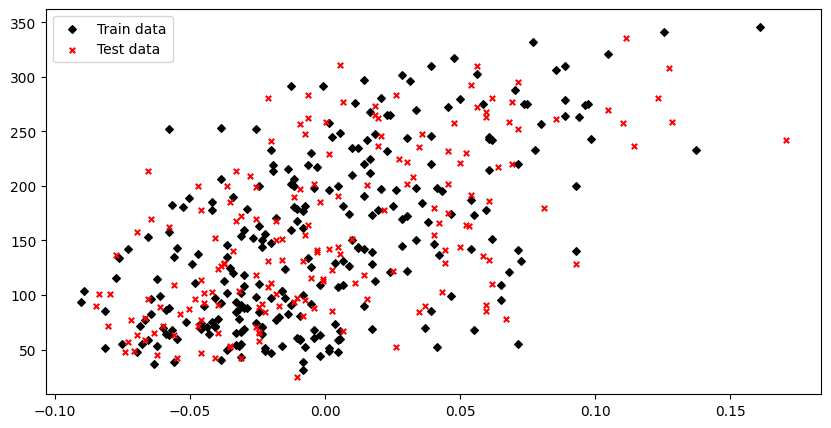

<Figure size 640x480 with 0 Axes>

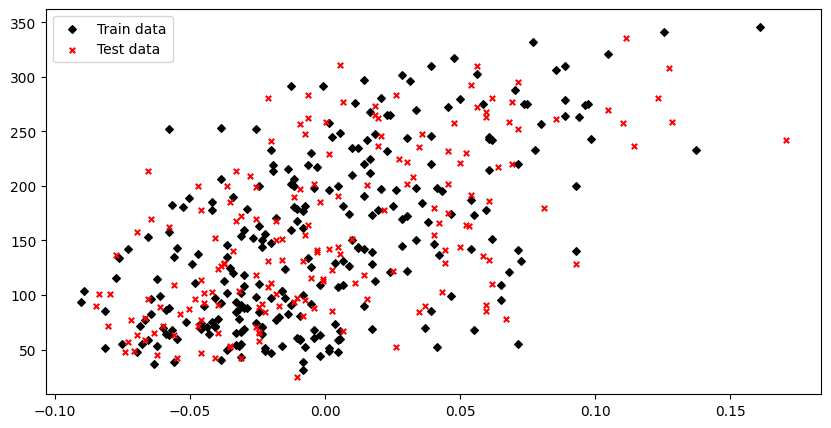

In [4]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.legend()
display(fig)

In [5]:
grid_scorer = make_scorer(mean_squared_error, greater_is_better=False)


In [6]:
param_grid = {
    "epsilon": [0.0, 1.0, 10.0, 20.0],
    "C": [0.1, 100.0, 10000.0, 100000.0],
}

sklearn_rgs = SklearnLinearSVR()
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=13)

gs_sklearn = GridSearchCV(
    sklearn_rgs,
    param_grid,
    cv=kfold_cv,
    scoring=grid_scorer,
    verbose=1,
).fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [7]:
param_grid = {
    "n_bits": [6, 8, 12],
    "epsilon": [0.0, 1.0, 10.0, 20.0],
    "C": [0.1, 100.0, 10000.0, 100000.0],
}

concrete_rgs = ConcreteLinearSVR()

gs_concrete = GridSearchCV(
    concrete_rgs,
    param_grid,
    cv=kfold_cv,
    scoring=grid_scorer,
    verbose=1,
).fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


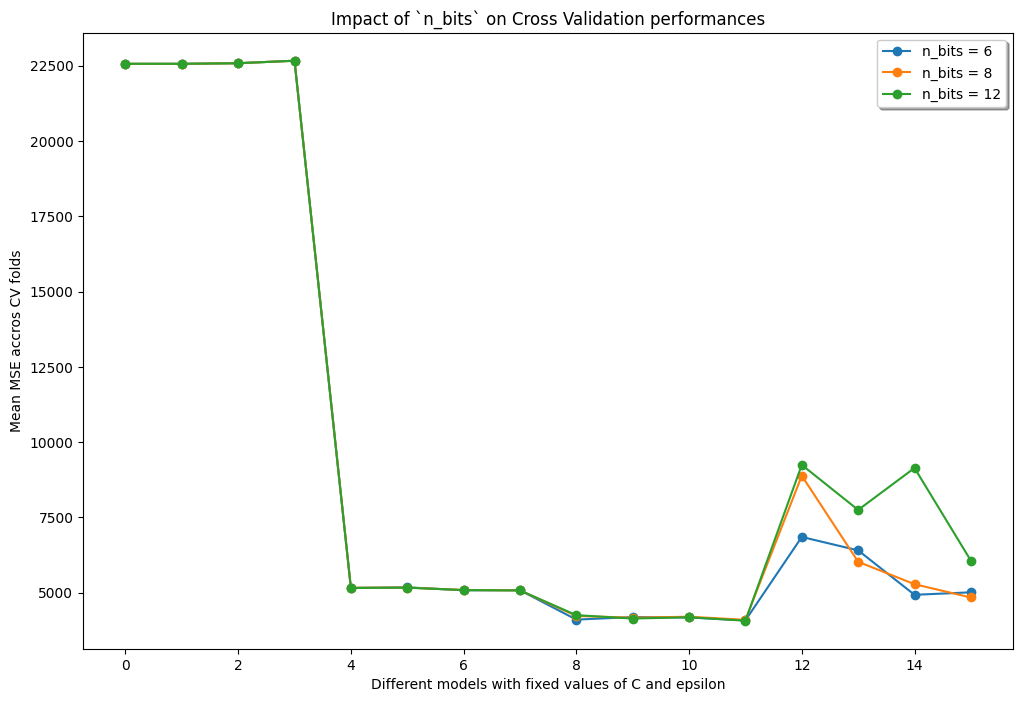

In [8]:
plt.ioff()

results_df = pd.DataFrame(gs_concrete.cv_results_)

fig, ax = plt.subplots(1, figsize=(12, 8))
(l1,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 6, "mean_test_score"], "-o"
)
(l2,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 8, "mean_test_score"], "-o"
)
(l3,) = ax.plot(
    np.arange(16), -results_df.loc[results_df["param_n_bits"] == 12, "mean_test_score"], "-o"
)
ax.legend((l1, l2, l3), ("n_bits = 6", "n_bits = 8", "n_bits = 12"), loc="upper right", shadow=True)
ax.set_xlabel("Different models with fixed values of C and epsilon")
ax.set_ylabel("Mean MSE accros CV folds")
ax.set_title("Impact of `n_bits` on Cross Validation performances")
display(fig)

In [9]:
# Print mean time fit and std time fit for both models
print(
    f"Mean time fit sklearn: {np.mean(gs_sklearn.cv_results_['mean_fit_time']):.3f}s,"
    f" std time fit sklearn: {np.std(gs_sklearn.cv_results_['mean_fit_time']):.3f}s"
)
print(
    f"Mean time fit concrete: {np.mean(gs_concrete.cv_results_['mean_fit_time']):.3f}s,"
    f"std time fit concrete: {np.std(gs_concrete.cv_results_['mean_fit_time']):.3f}s"
)

# Print best score for both models
print(f"Best MSE score sklearn: {-gs_sklearn.best_score_:.2f}")
print(f"Best MSE score concrete: {-gs_concrete.best_score_:.2f}")

Mean time fit sklearn: 0.002s, std time fit sklearn: 0.002s
Mean time fit concrete: 0.055s,std time fit concrete: 0.004s
Best MSE score sklearn: 4102.09
Best MSE score concrete: 4070.91


In [10]:
# Get best hyperparameters out of gs_concrete
best_params_concrete = gs_concrete.best_params_
print(f"Best parameters for Concrete: {best_params_concrete}")
best_params_sklearn = gs_sklearn.best_params_
print(f"Best parameters for Sklearn: {best_params_sklearn}")

Best parameters for Concrete: {'C': 10000.0, 'epsilon': 20.0, 'n_bits': 12}
Best parameters for Sklearn: {'C': 10000.0, 'epsilon': 20.0}


In [11]:
# Train concrete and sklearn LinearSVR with best hyper parameters
concrete_rgs = ConcreteLinearSVR(**best_params_concrete)

concrete_rgs, sklearn_rgs = concrete_rgs.fit_benchmark(X_train, y_train)

In [15]:
# Compile the model using the training data
# print(concrete_rgs.compile.__code__.co_varnames)
circuit = concrete_rgs.compile(X = X_train)

NO target: Unable to find target for this triple (no targets are registered)


RuntimeError: No default target machine for object generation

In [ ]:
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")


In [ ]:
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

In [ ]:
# Now predict using the FHE-quantized model on the testing set
time_begin = time.time()
y_pred_fhe = concrete_rgs.predict(X_test, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

# Now predict using the Sklearn model on the testing set
time_begin = time.time()
y_pred_sklearn = sklearn_rgs.predict(X_test)
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

# Now predict using clear quantized Concrete-ML model on testing set
time_begin = time.time()
y_preds_quantized = concrete_rgs.predict(X_test)
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

In [ ]:
# We densify the space representation of the original X,
# to better visualize the resulting step function in the following figure
x_space = np.linspace(X_test.min(), X_test.max(), num=300)
x_space = x_space[:, np.newaxis]
y_pred_q_space = concrete_rgs.predict(x_space)